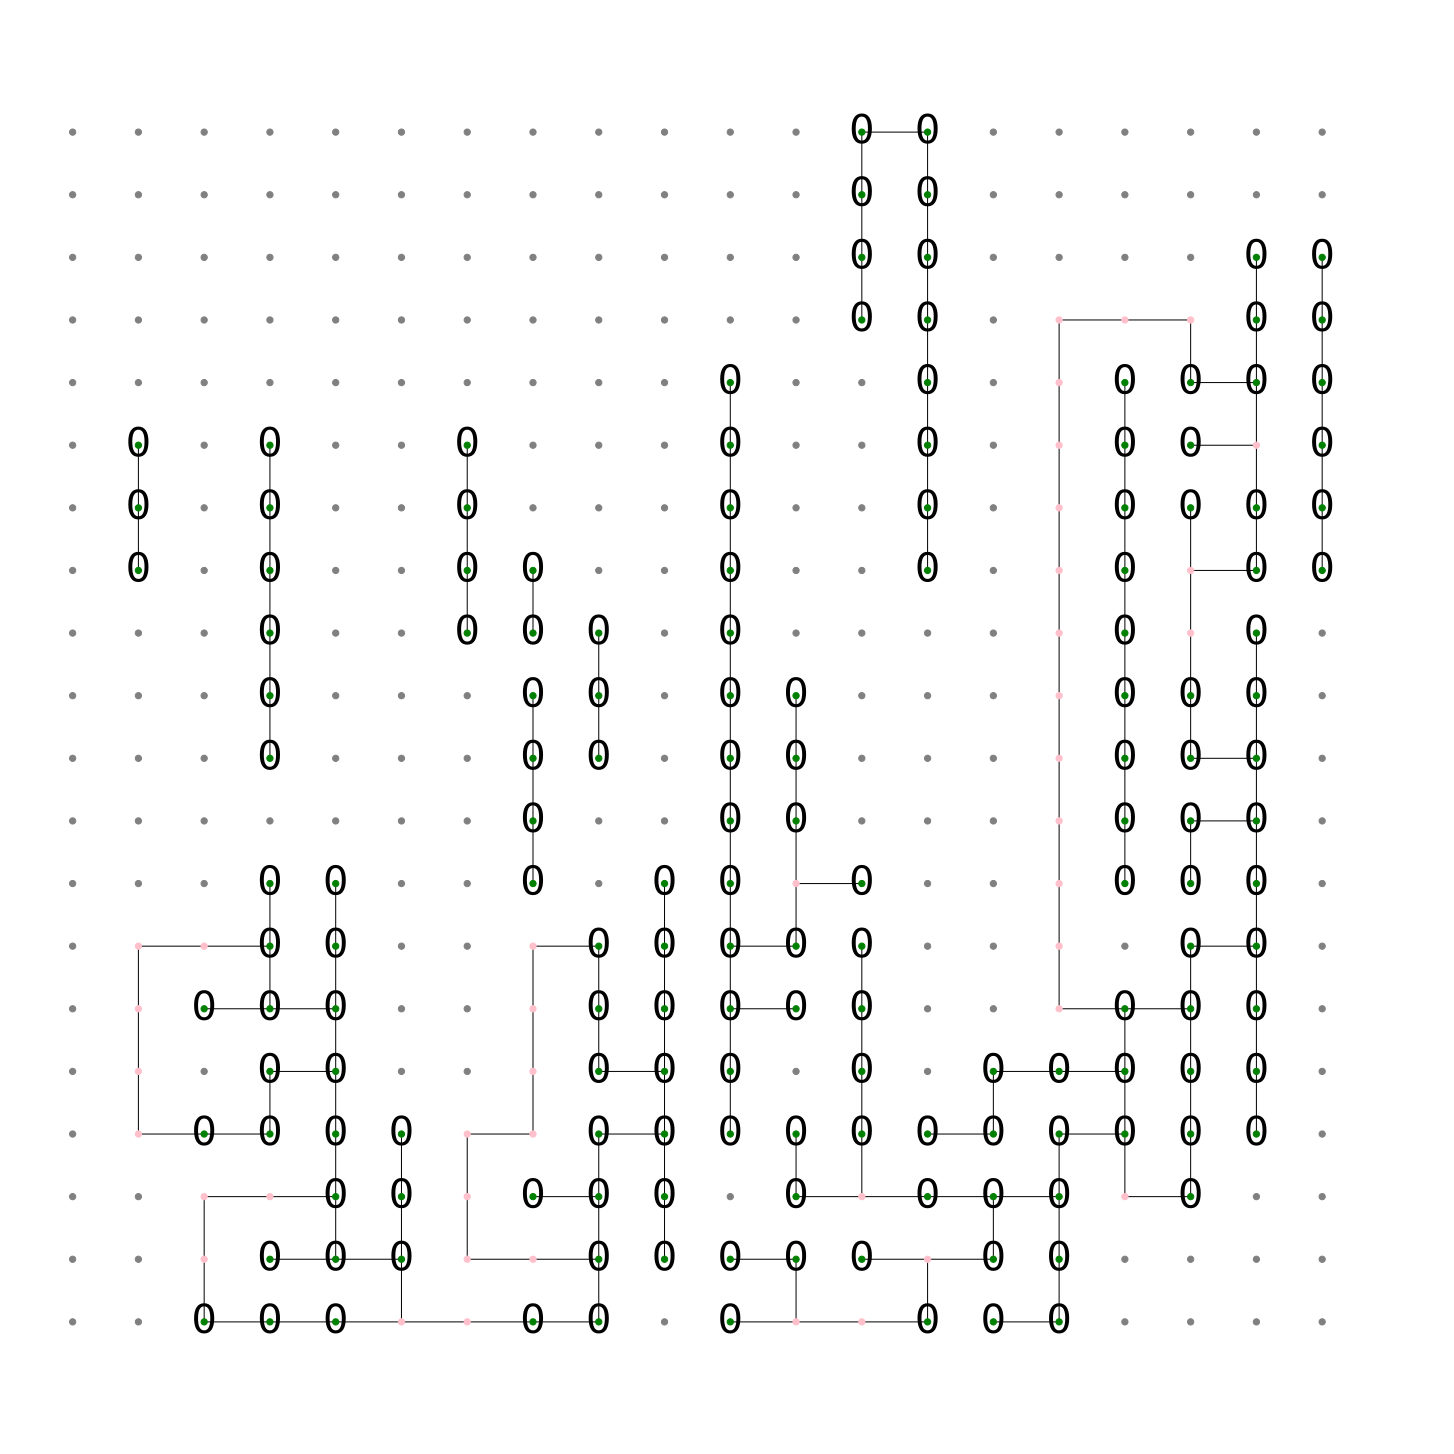

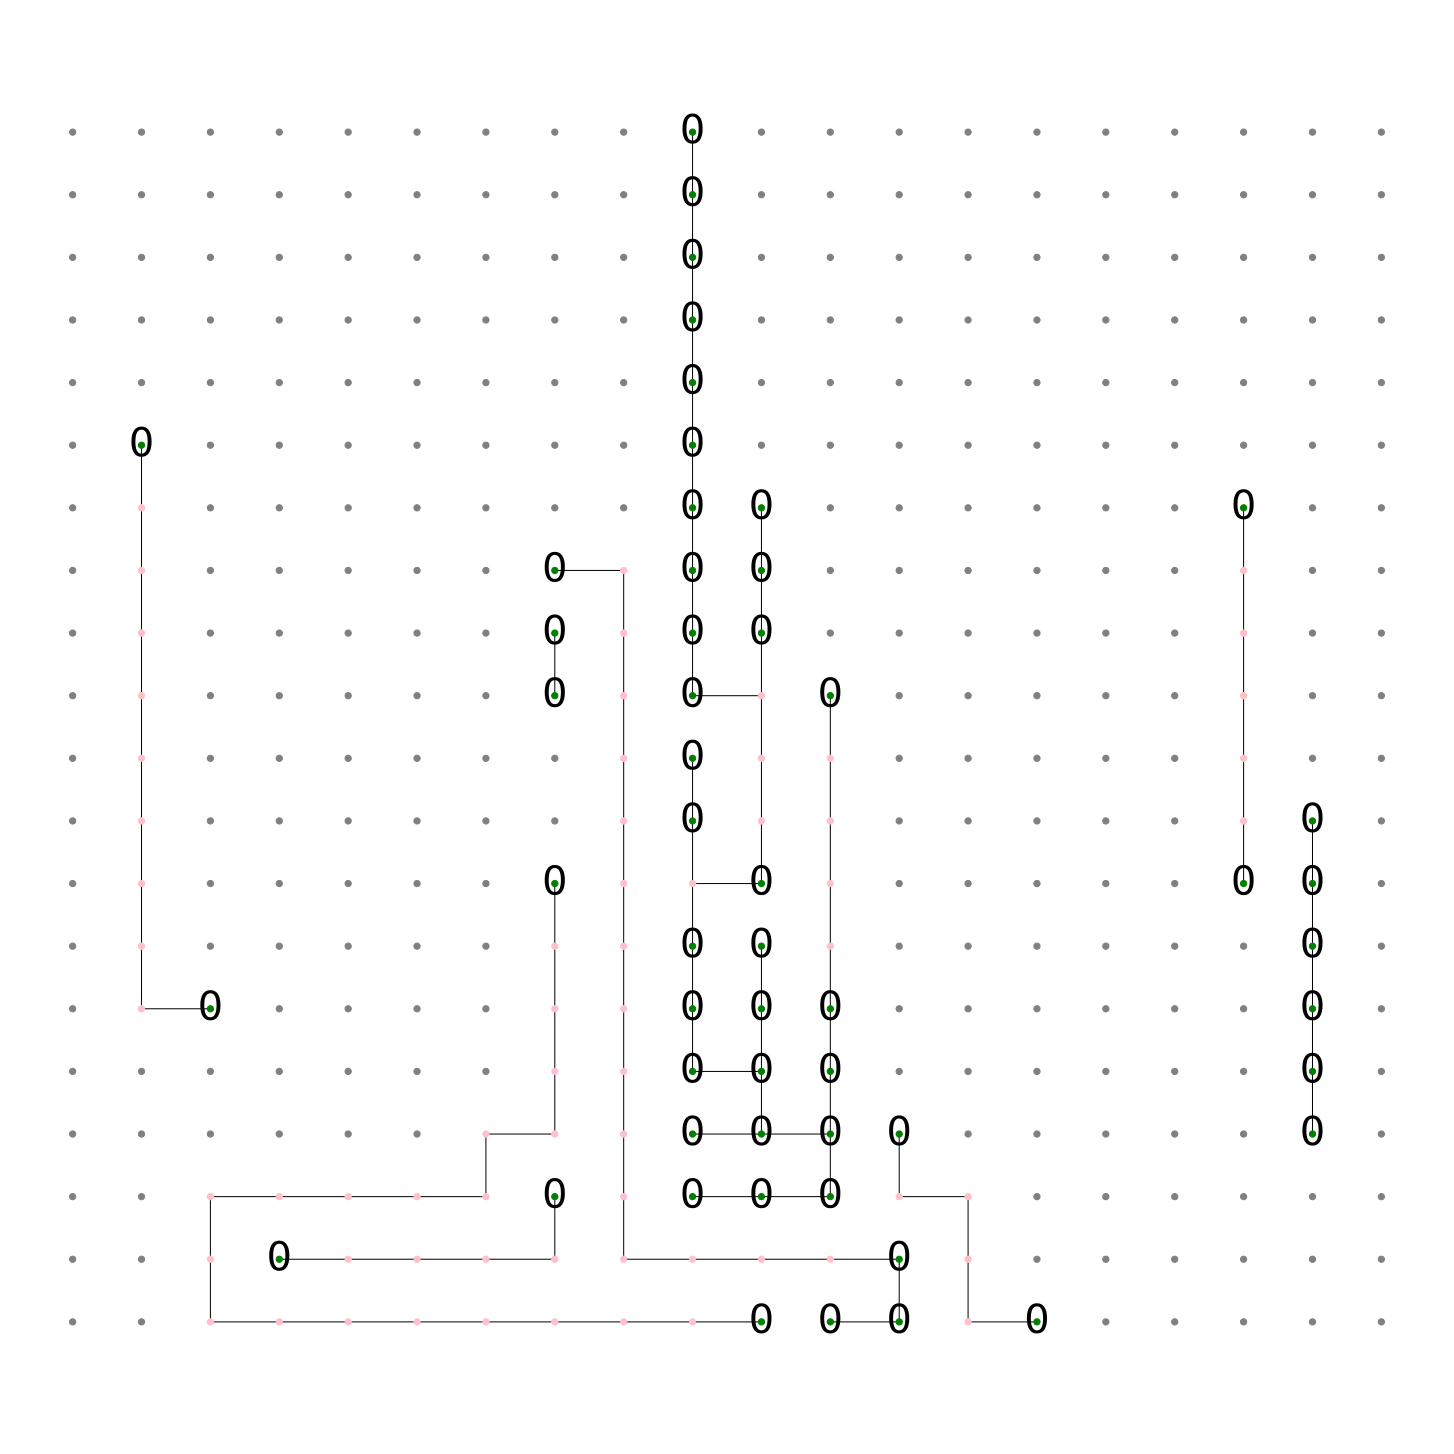

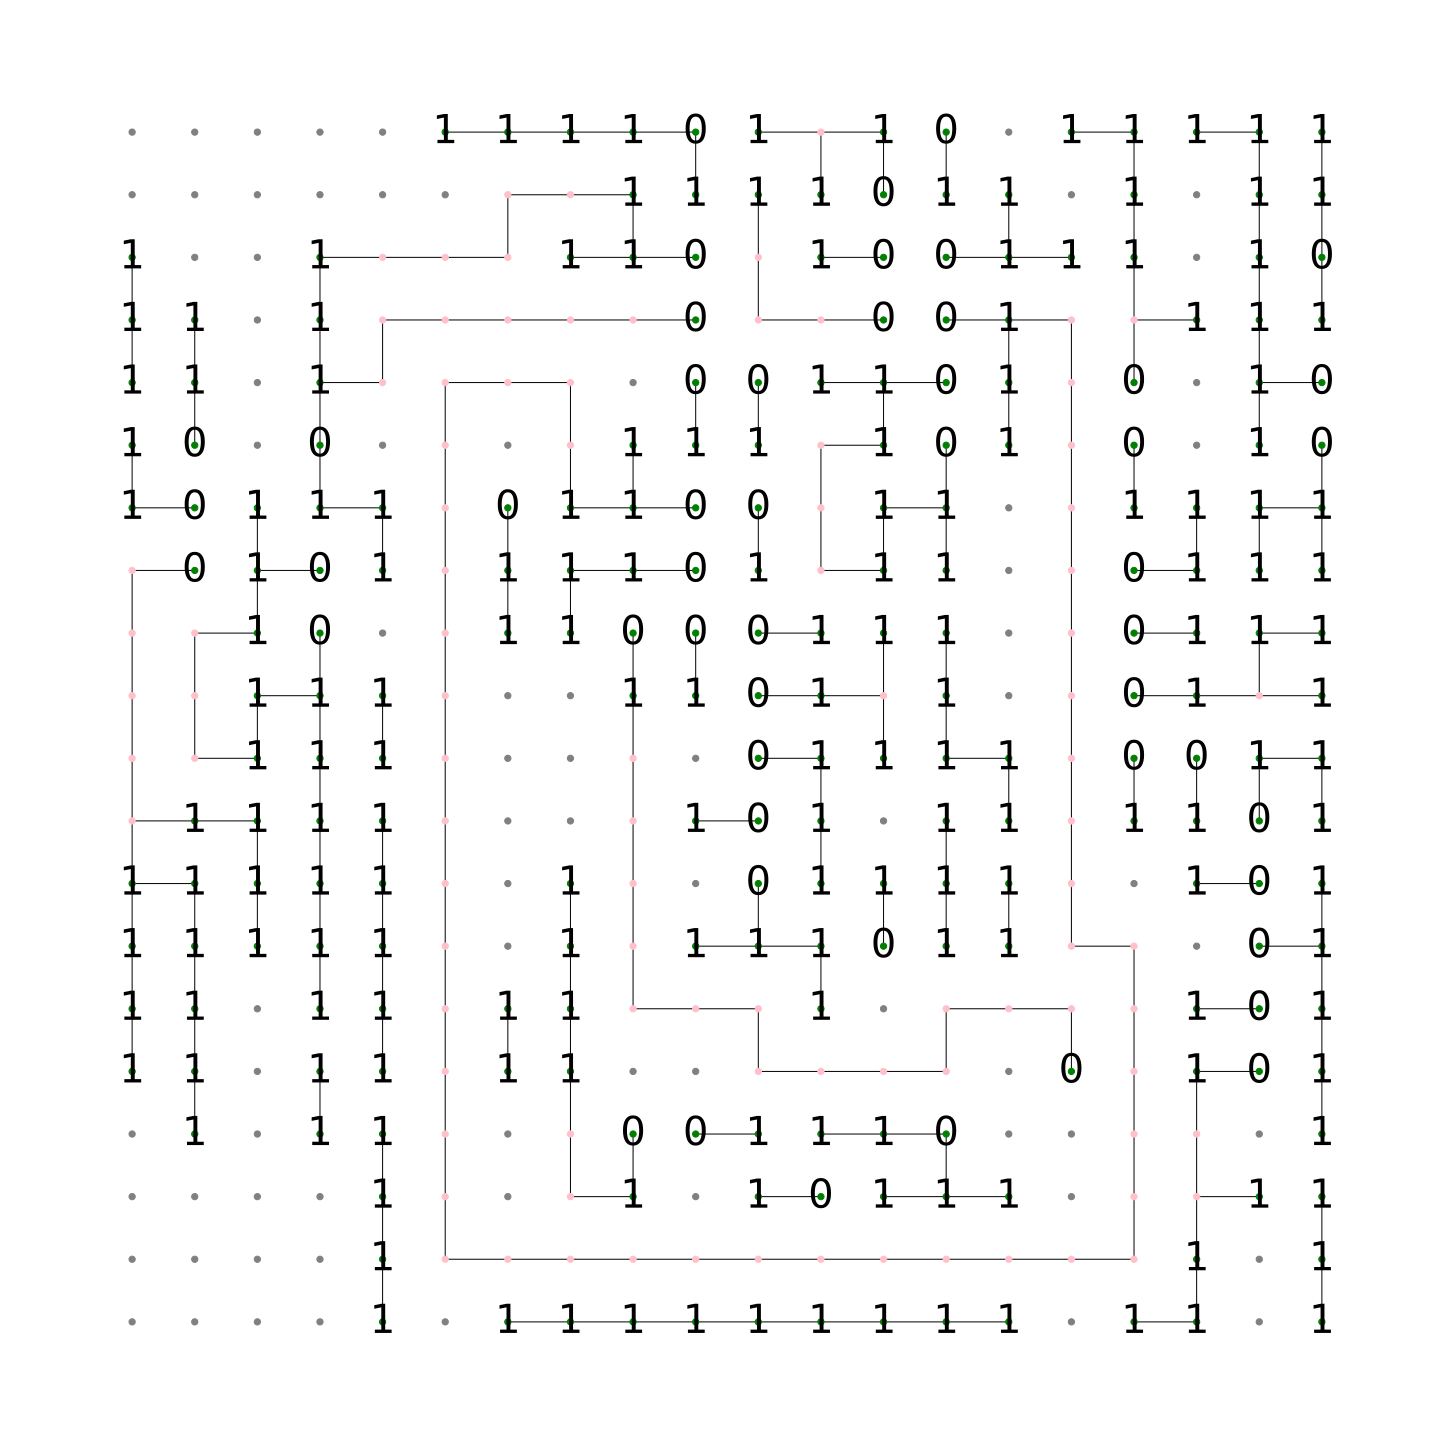

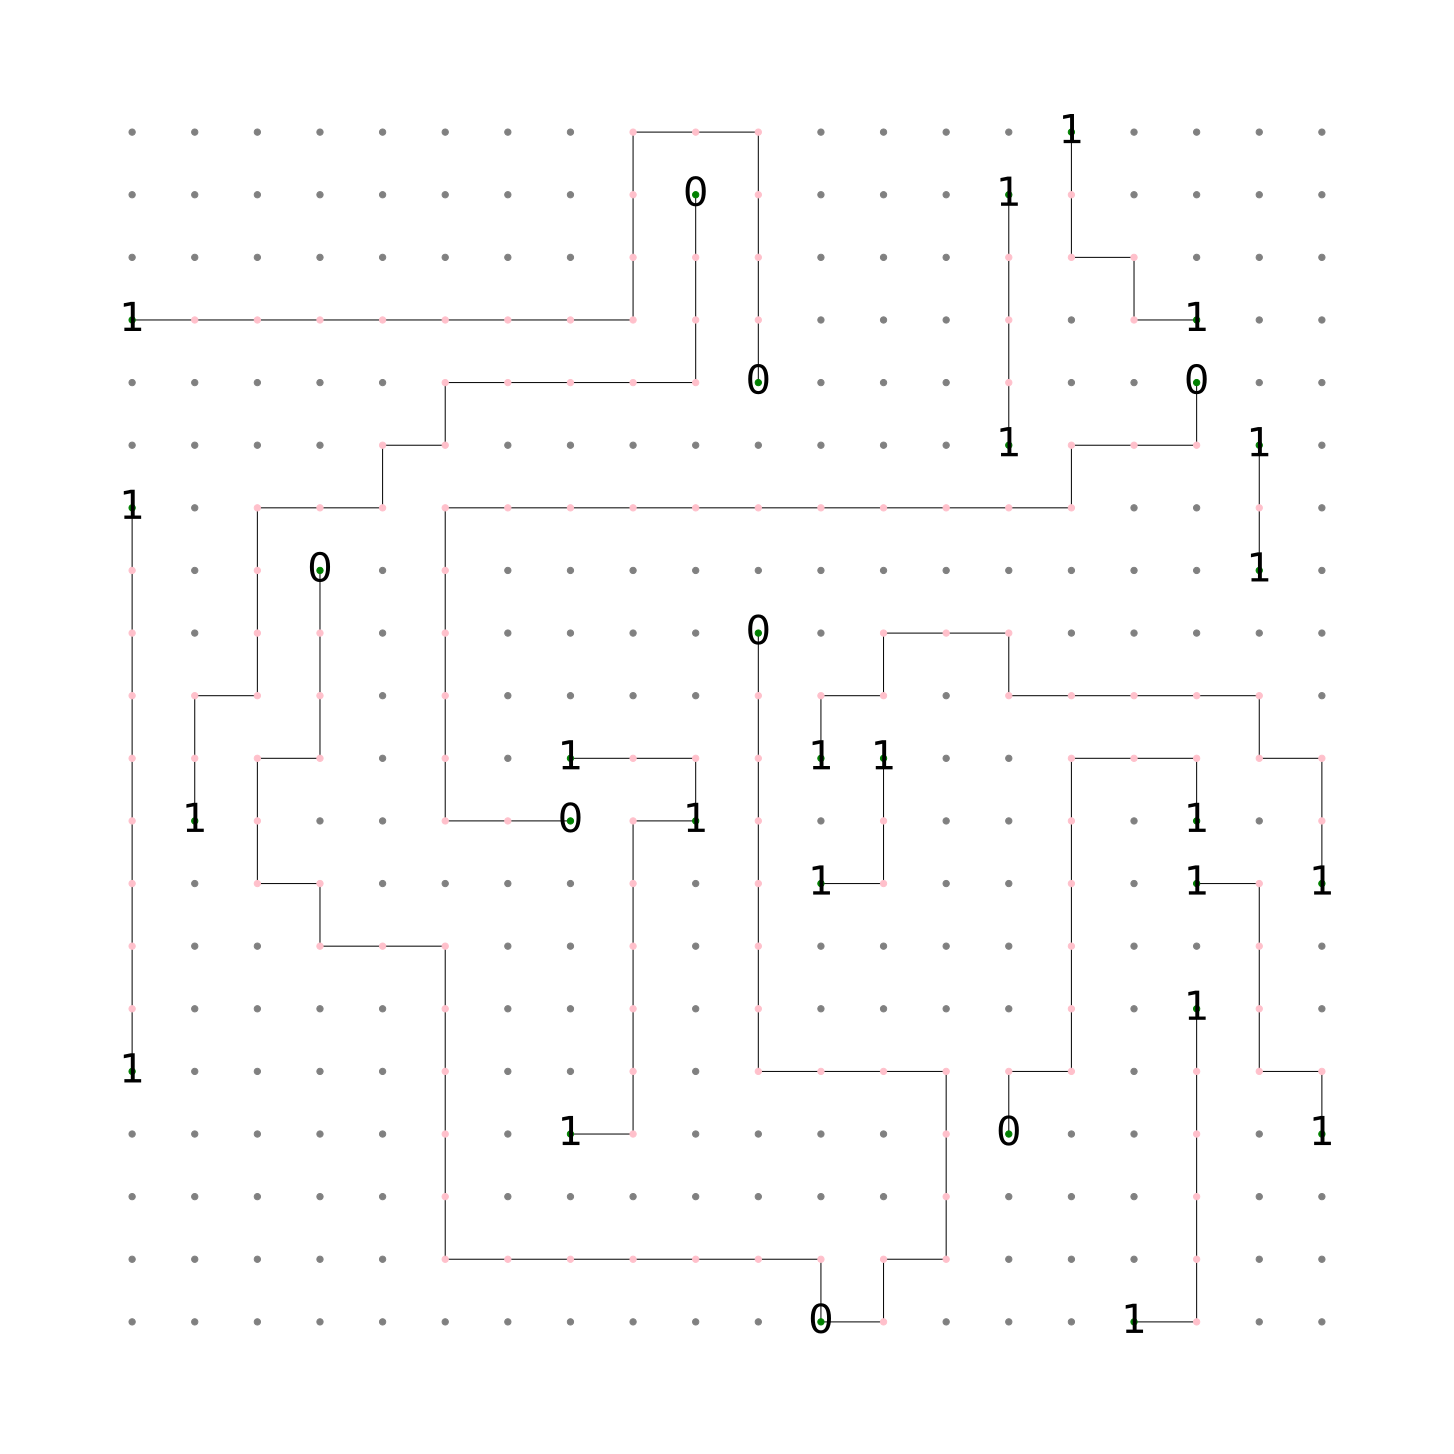

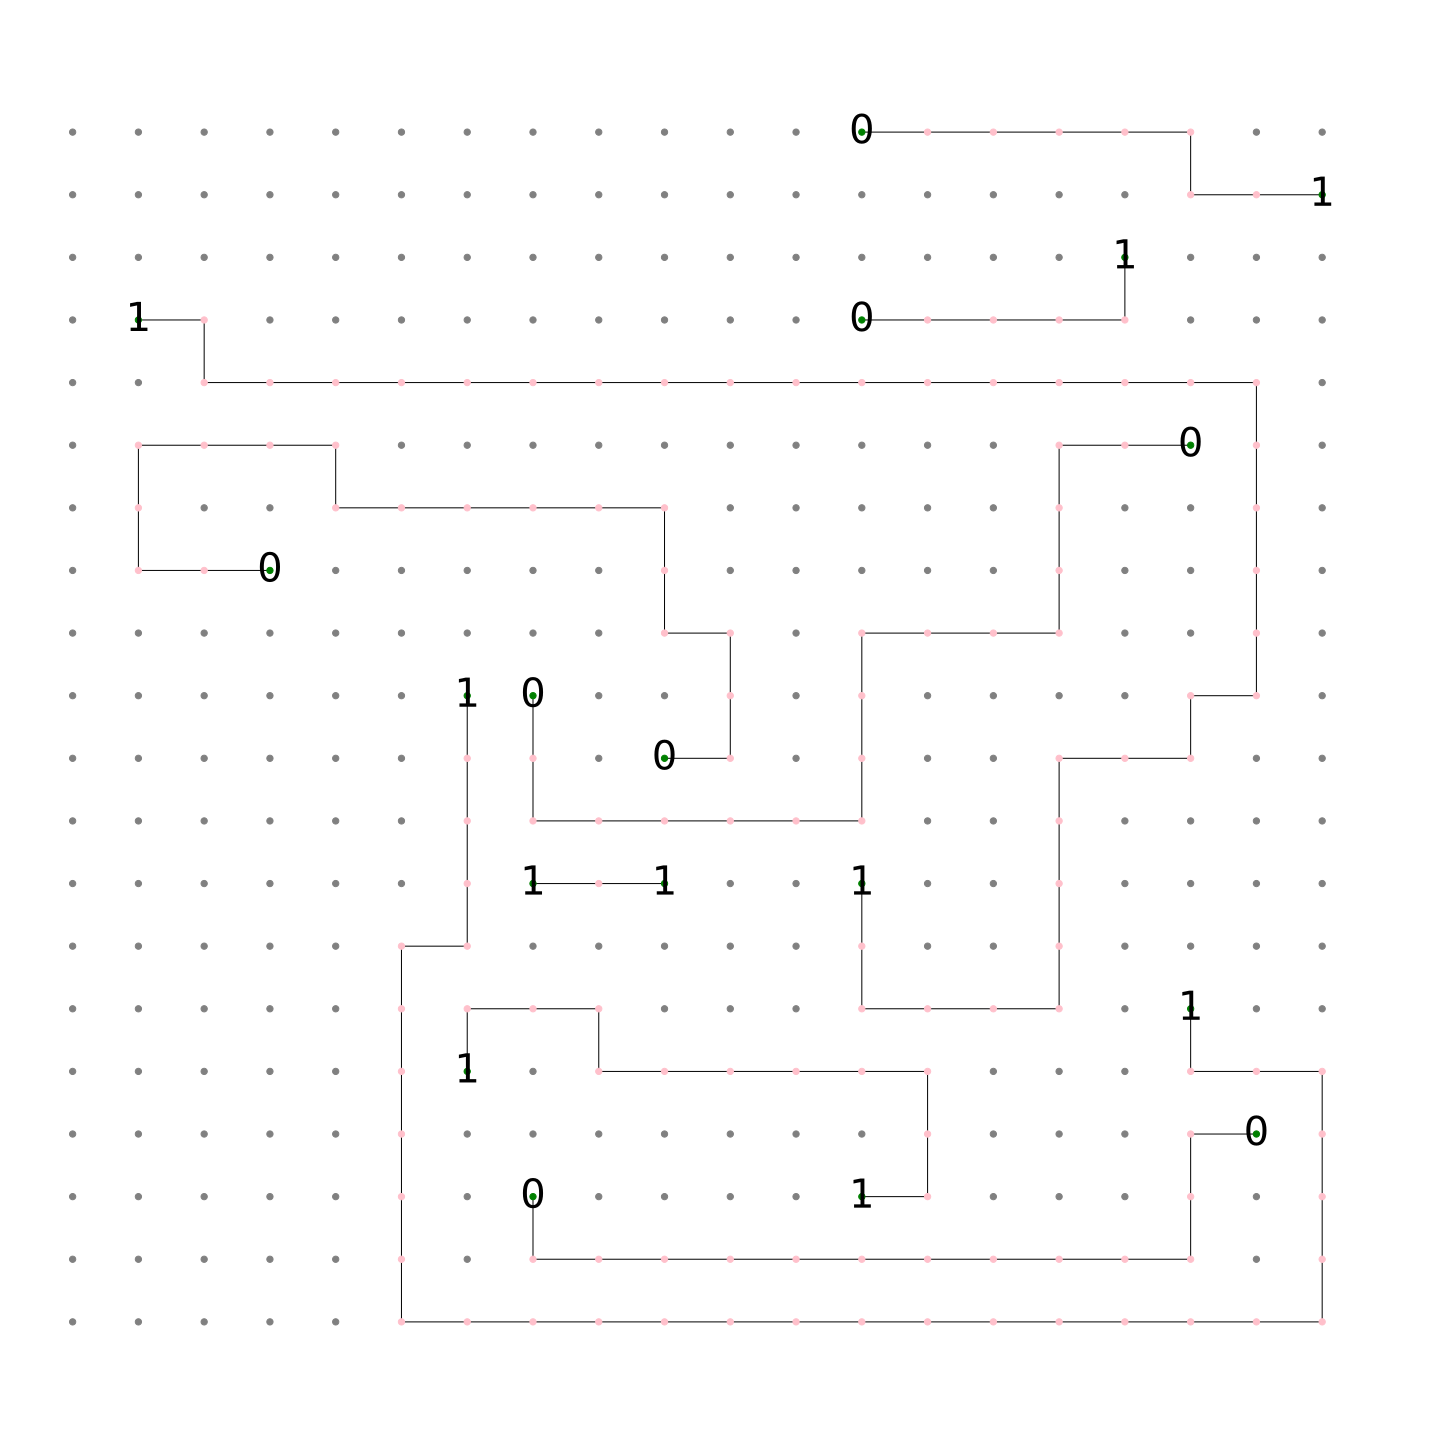

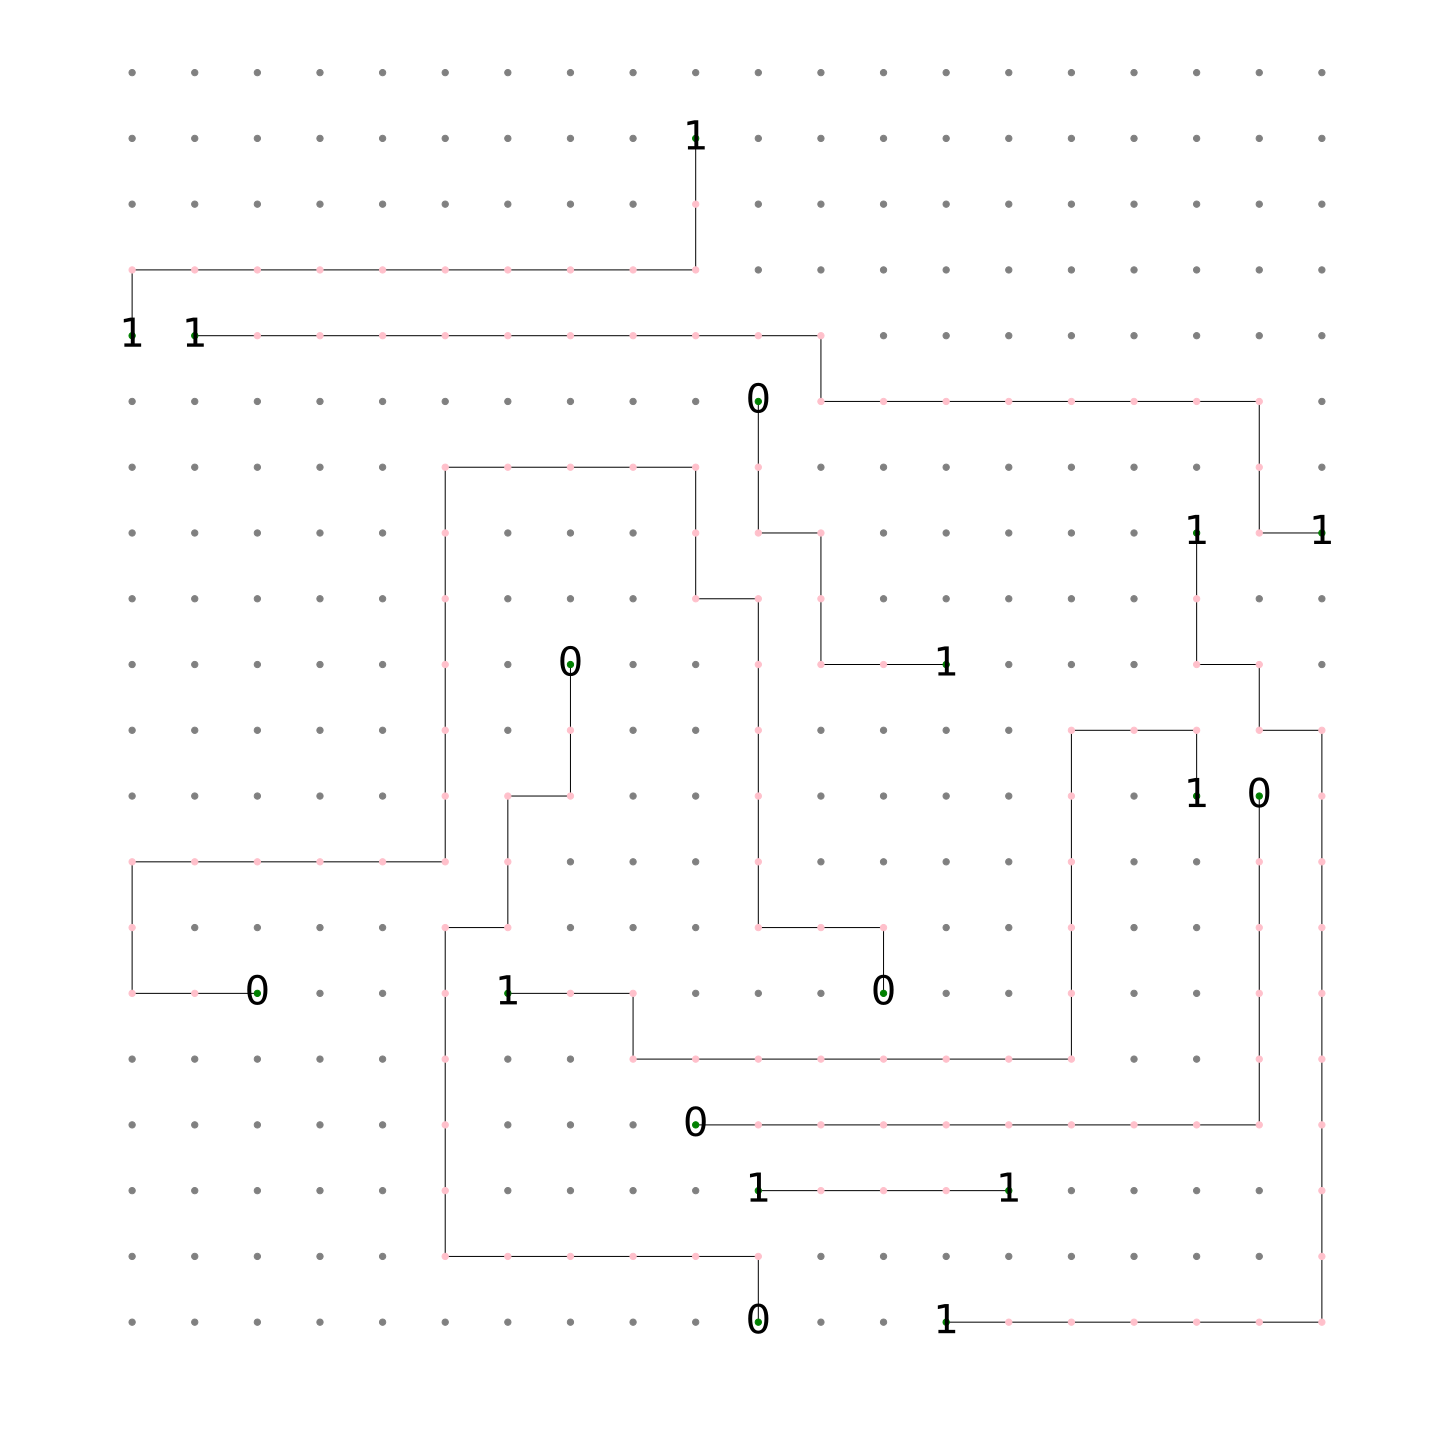

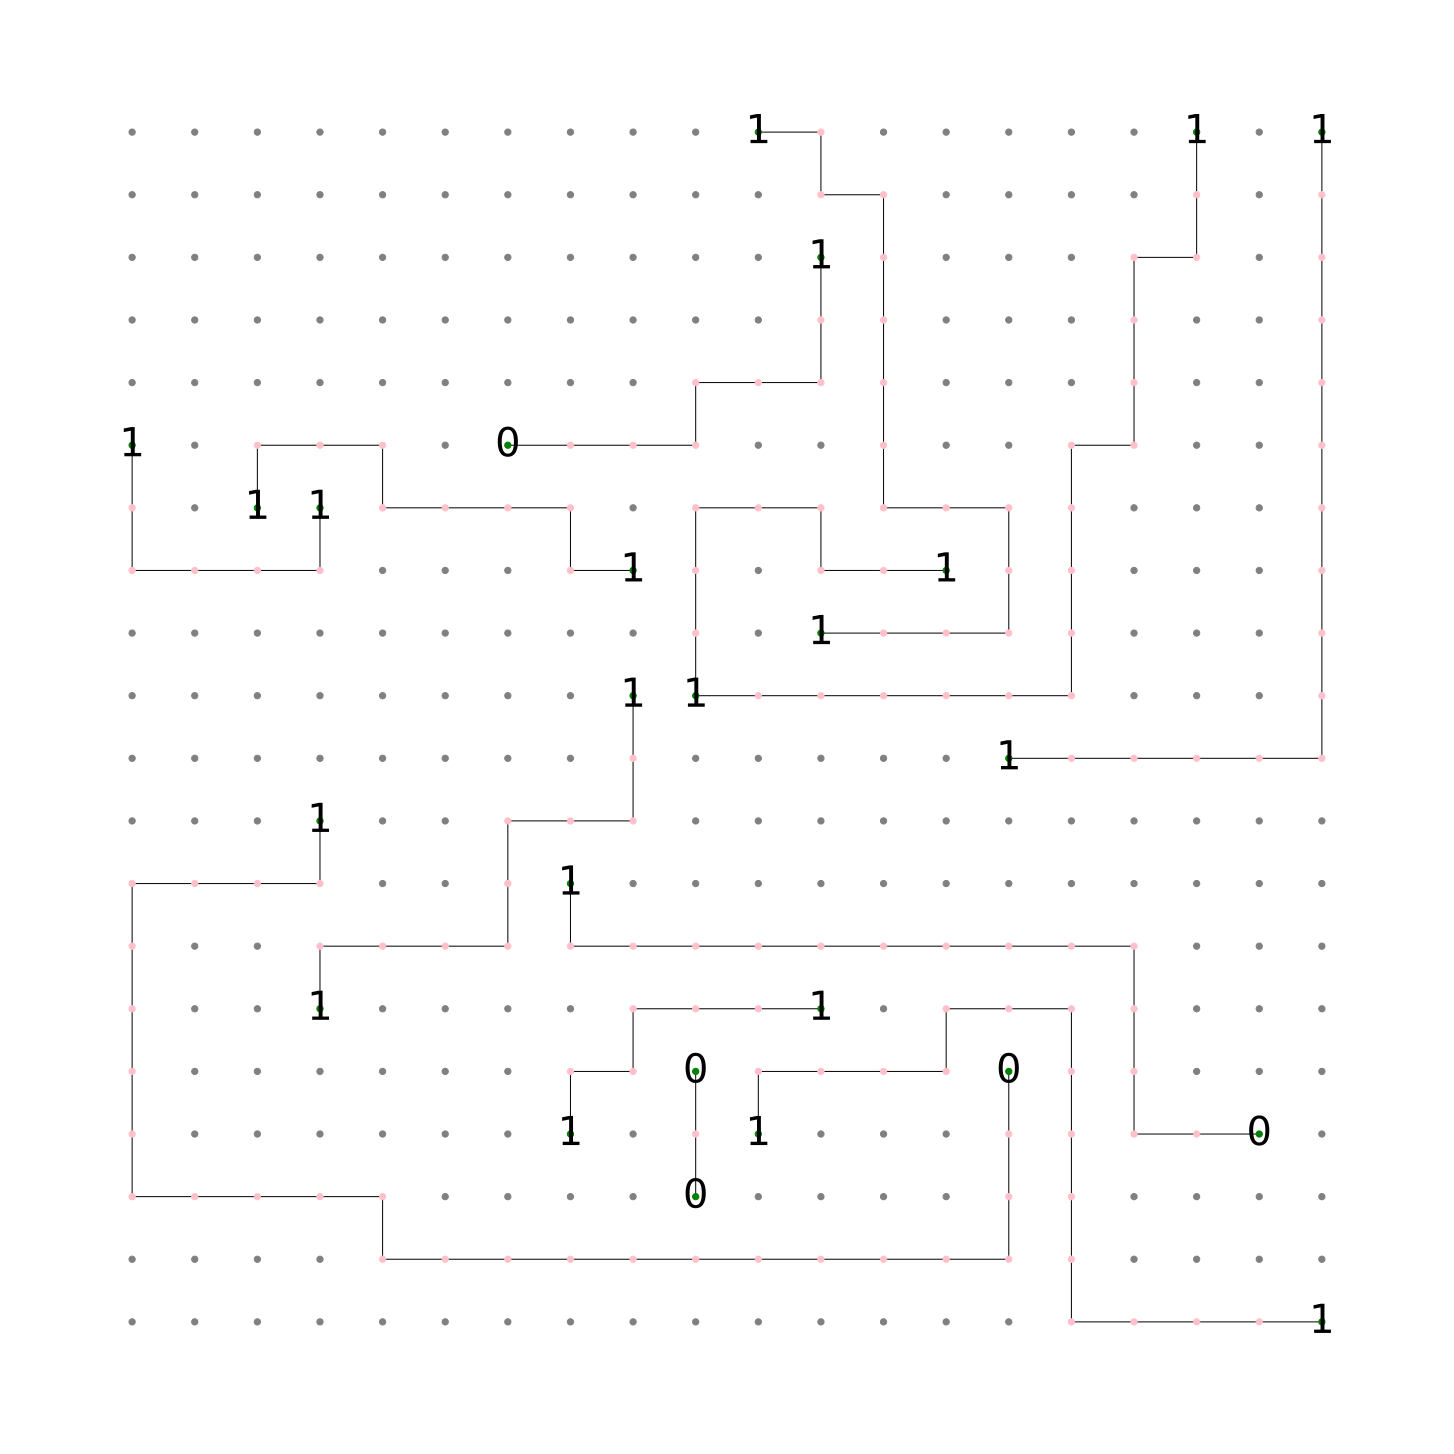

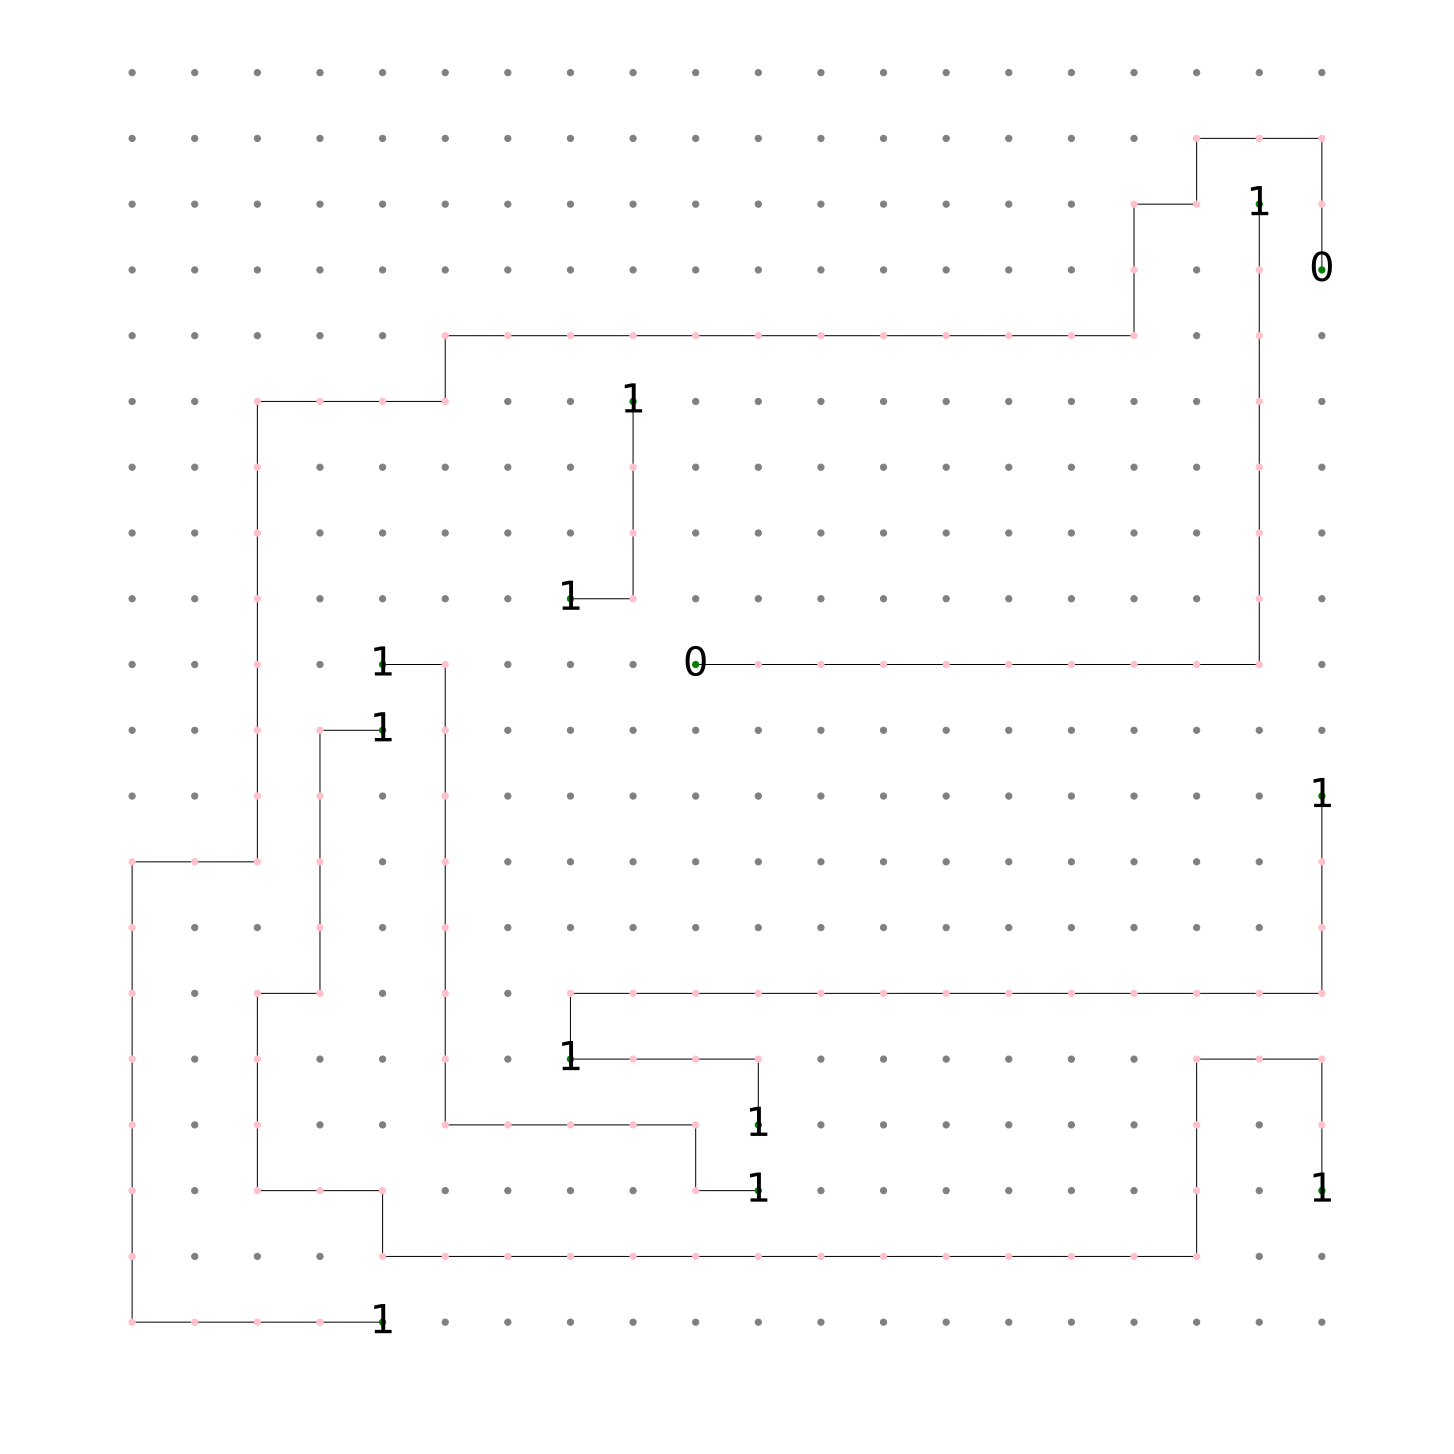

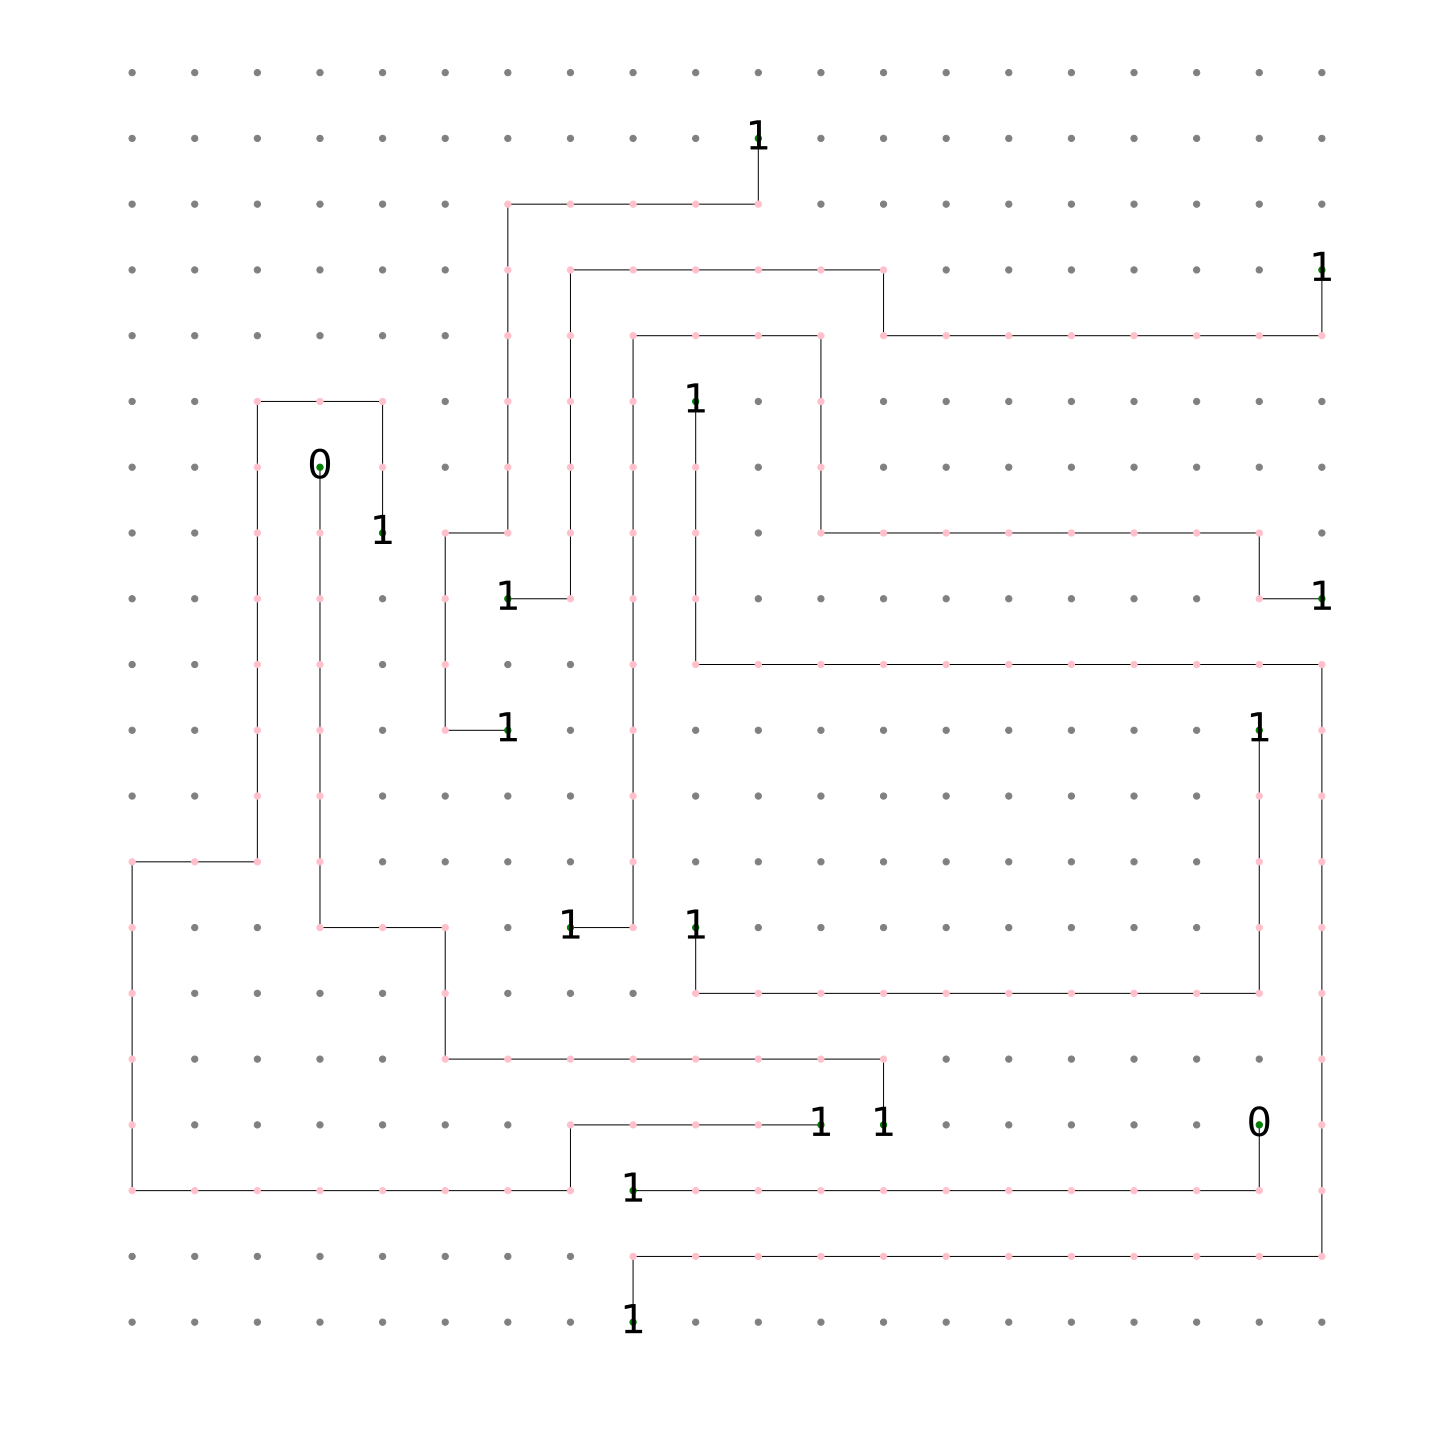

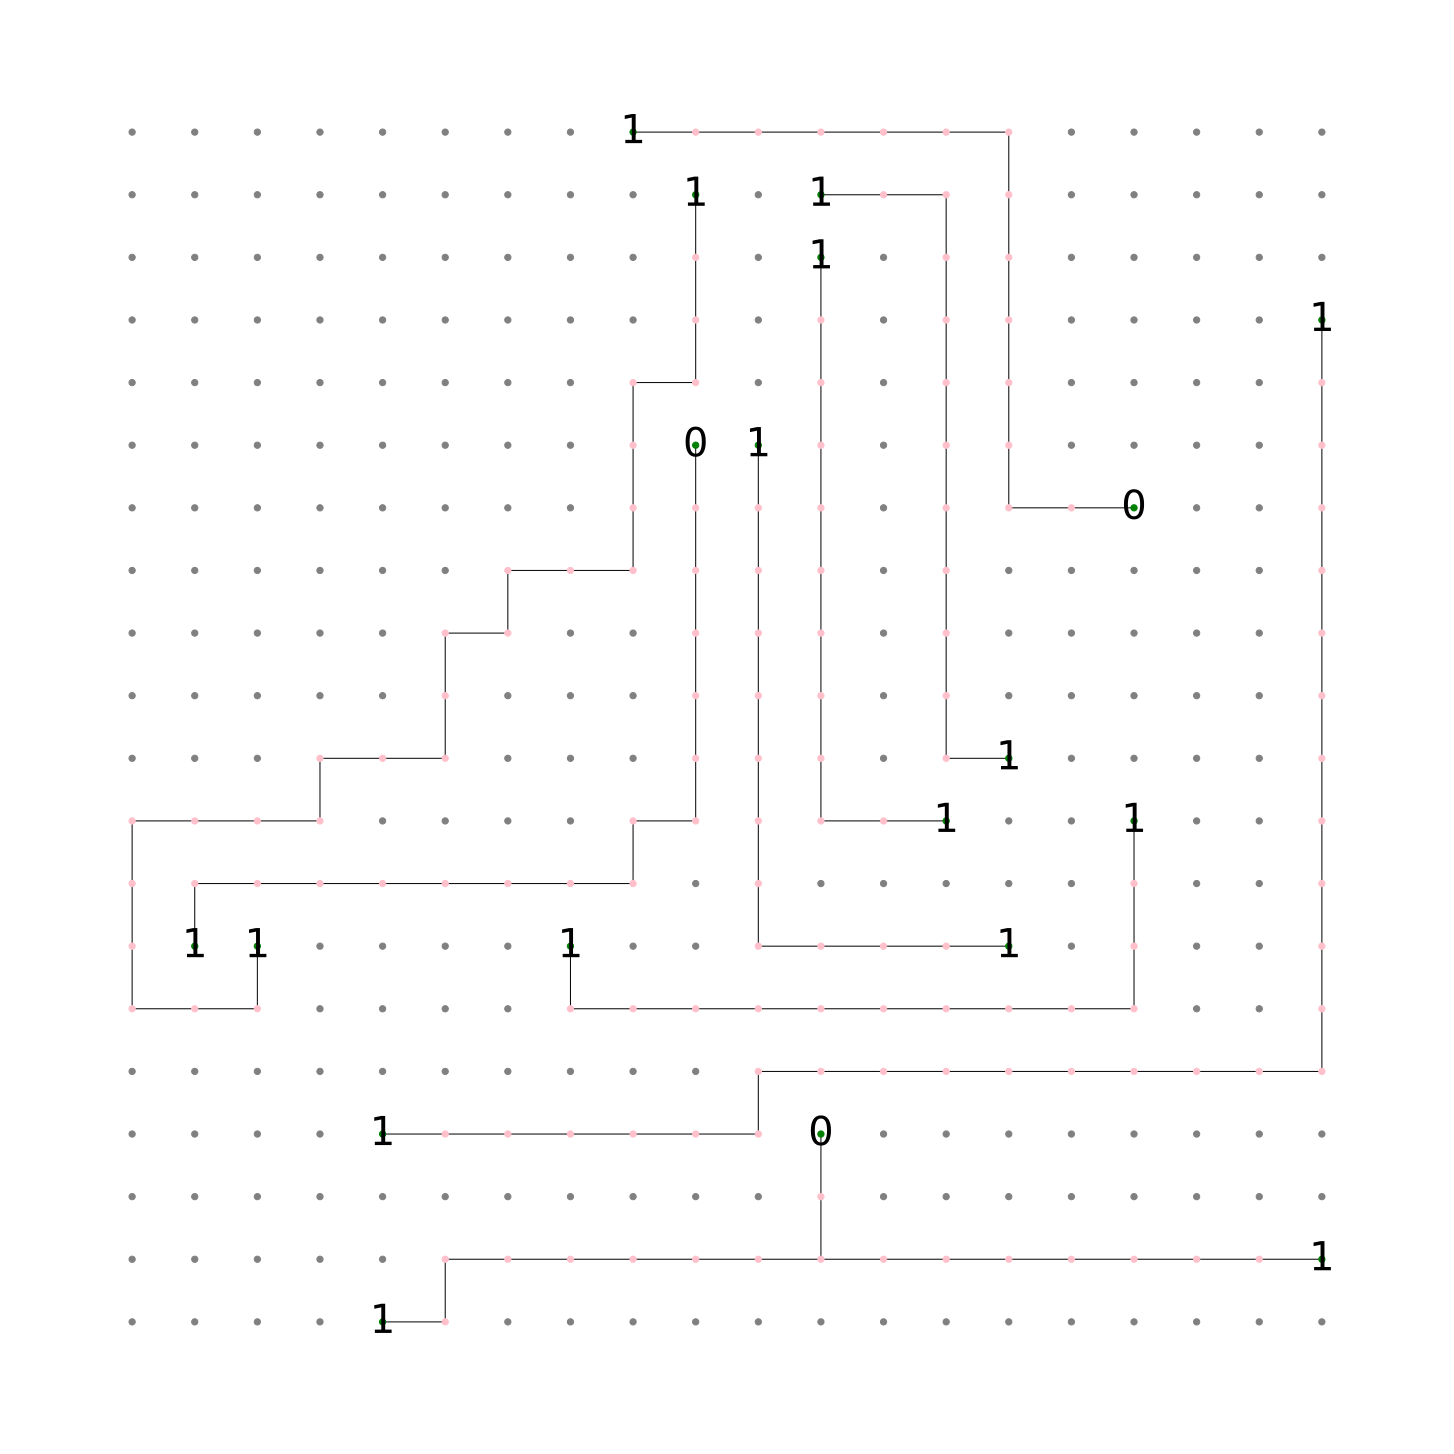

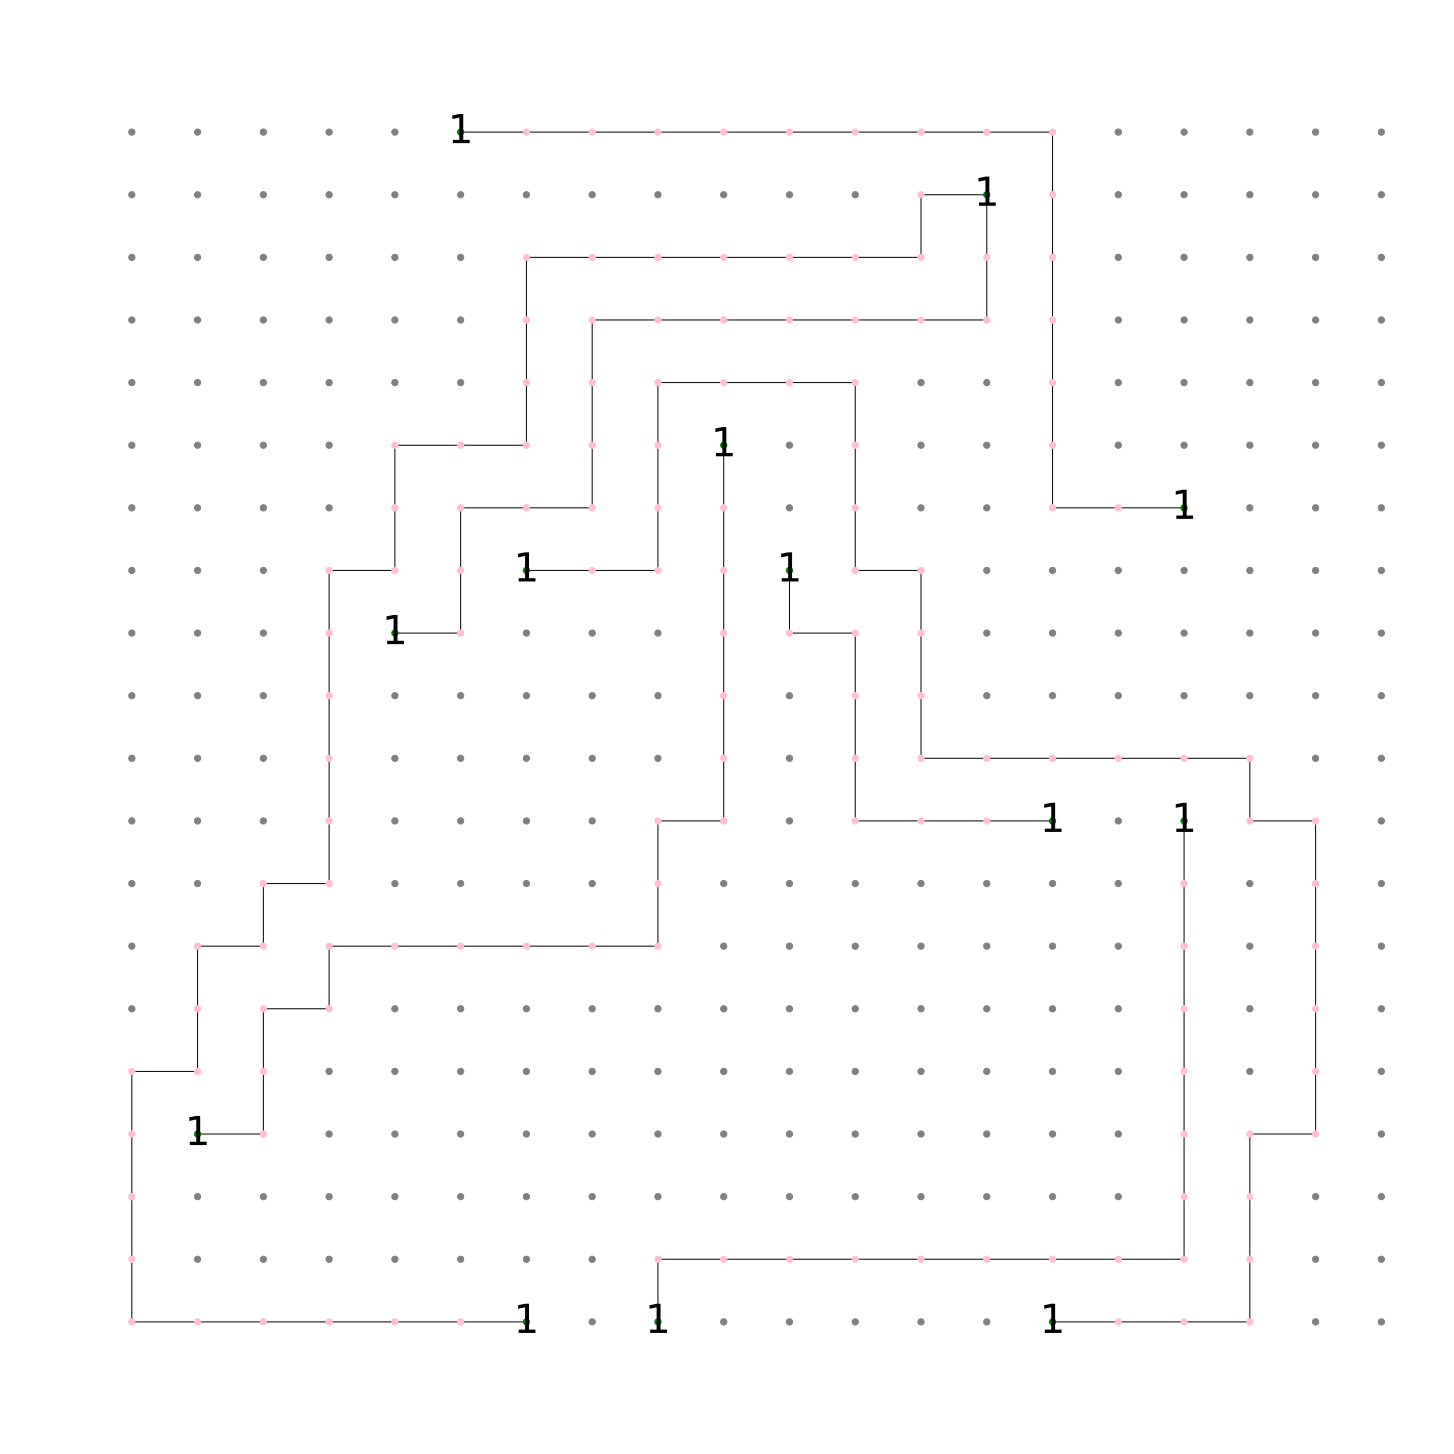

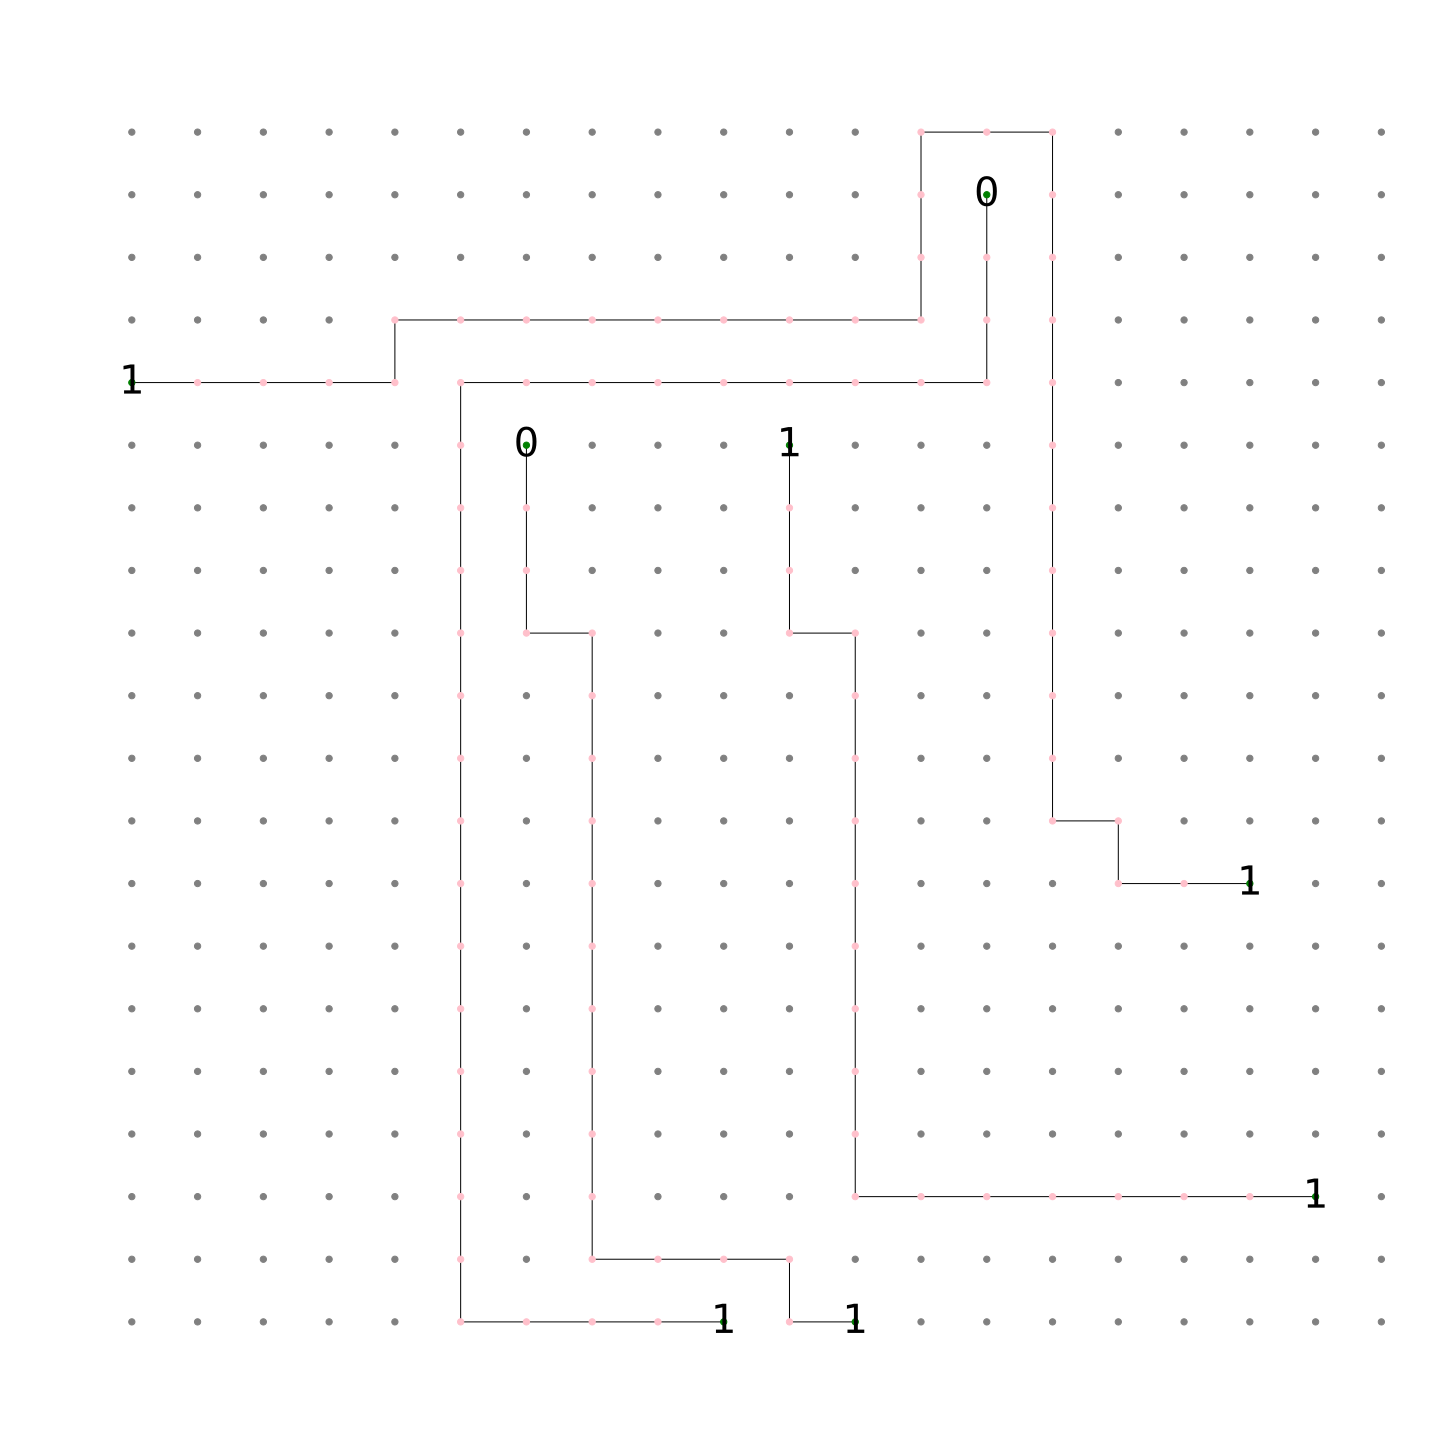

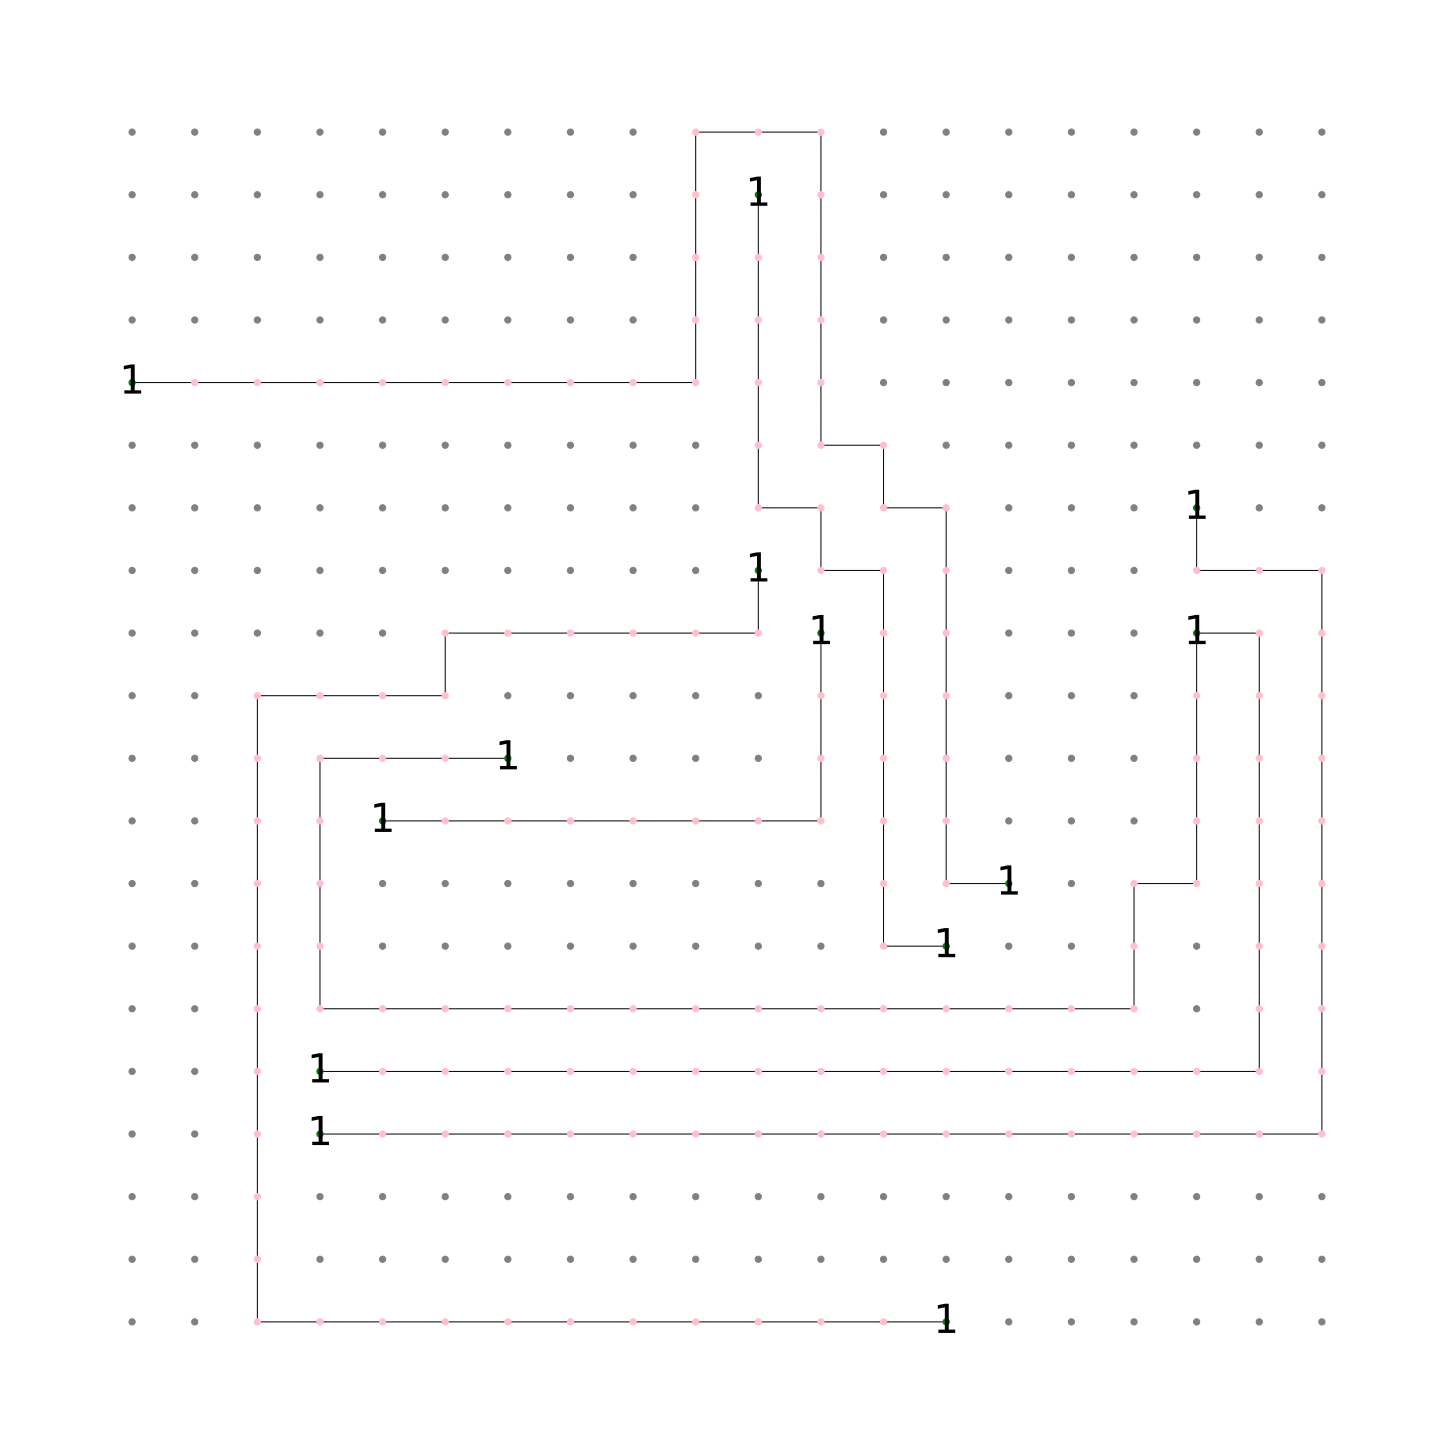

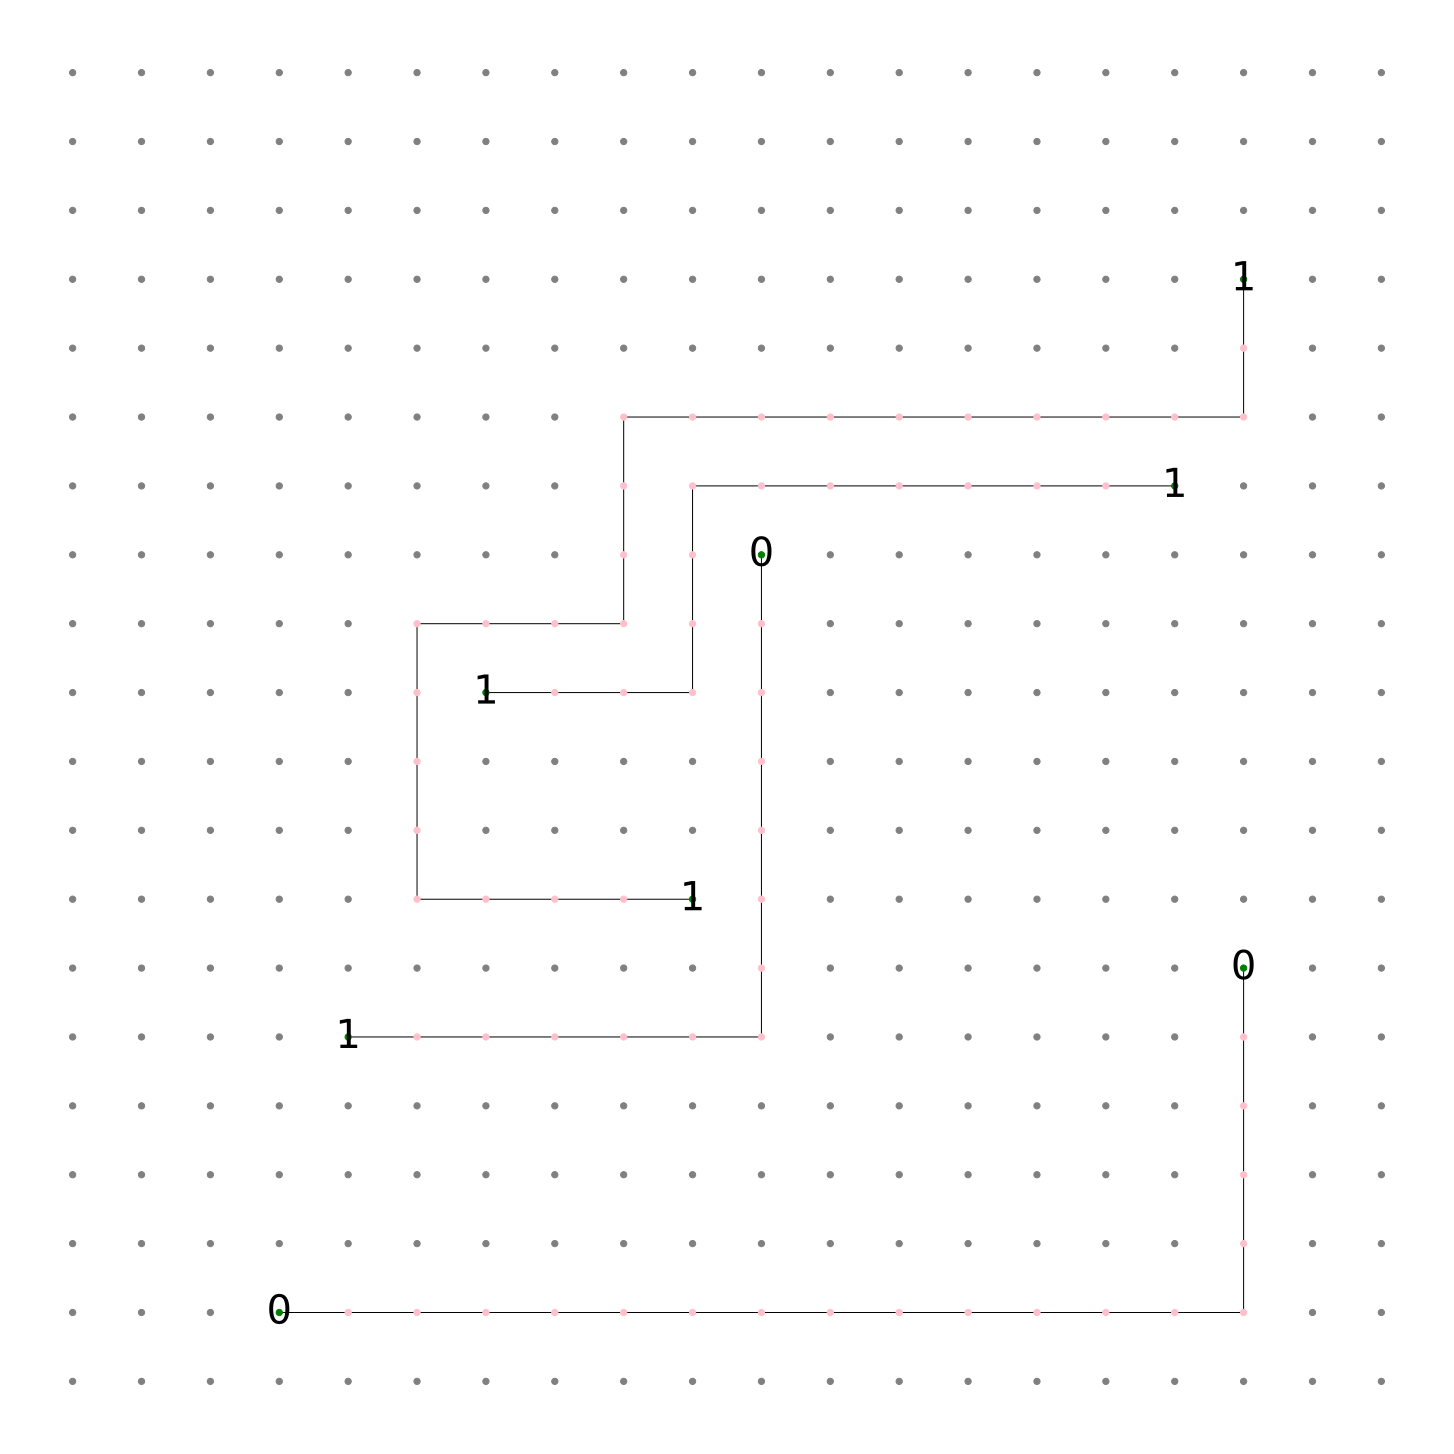

391 nodes
14 layers
fusion: 2105
begin to validate!
validate success!


In [1]:
from Schedule import *
from Fusion import *
from Graph_State import *
from Compact_Graph import *
from Validate import *
from Construct_Test_Circuit import *
from Add_Round import *
from Determine_Dependency import *
from Generalized_Flow import *

NQubit = 16
Depth = 400
MaxDegree = 3
Generalized_Flow_Flag = True

def to_undirected(gs):
    undirected_graph = nx.Graph()
    for nnode in gs.nodes():
        undirected_graph.add_node(nnode)
        if not Generalized_Flow_Flag:
            undirected_graph.nodes[nnode]['layer'] = gs.nodes[nnode]['layer']
    for edge in gs.edges():
        if edge not in undirected_graph.edges():
            undirected_graph.add_edge(edge[0], edge[1])
    return undirected_graph

def main():
    # construct circuit
    # gates_list, qubits = generate_circuit(NQubit, Depth)
    gates_list, qubits = construct_qaoa(NQubit, 0.5)

    # generate graph state
    gs, colors = generate_graph_state(gates_list, qubits)

    # causal flow
    if not Generalized_Flow_Flag:
        dgraph = determine_dependency(gs)
        gs = schedule(gs, dgraph)
    # gs = partition(gs, input_nodes)
    undirected_graph = to_undirected(gs)

    # generalized flow
    if Generalized_Flow_Flag:
        undirected_graph = generaized_flow(undirected_graph)
    
    # fusion
    fgraph, added_nodes = fusion_graph(undirected_graph, MaxDegree)
    
    # add rounds
    fgraph = add_round(fgraph, 2)
    
    # map and route
    net_list = compact_graph(fgraph)
    
    # show result
    fusions = 0
    for net in net_list:
        fusions += len(list(net.edges()))
    print("fusion:", fusions)
    fgraph = validate(net_list, fgraph)   
    return

if __name__ == '__main__':
    main()